Upload mean: 35.541029411764704 Mbits/s
Upload deviation: 13.48057066639463 Mbits/s
Confidence interval: (32.278036160687165, 38.80402266284224)




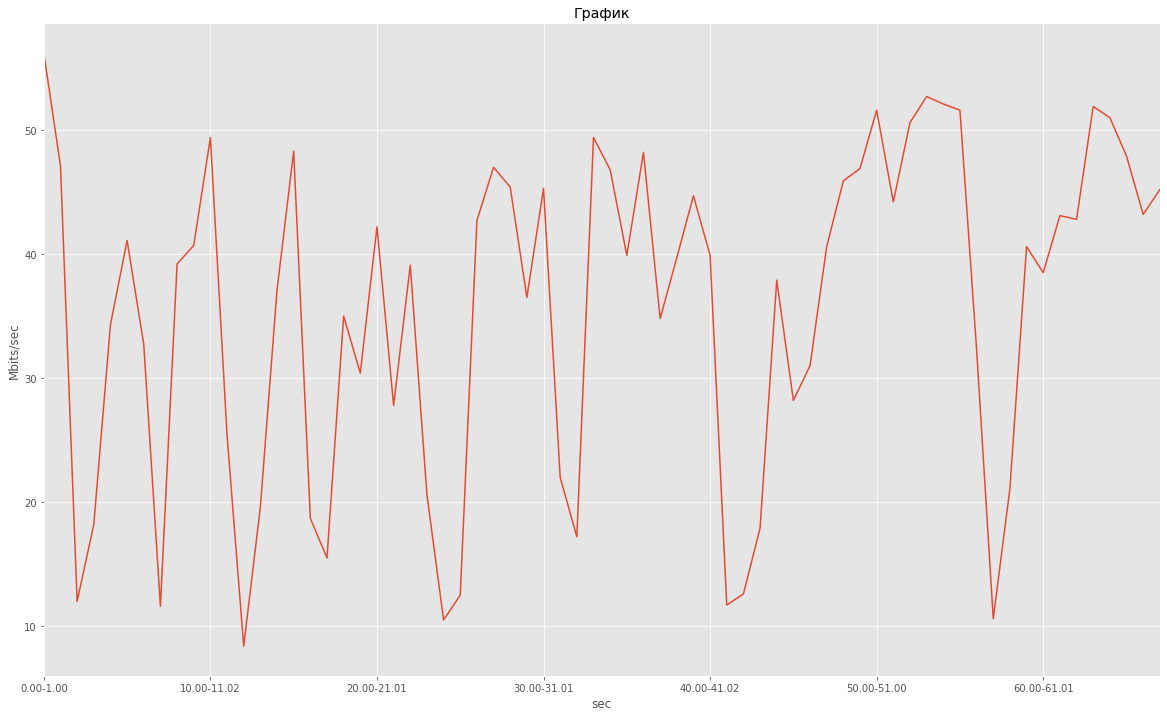

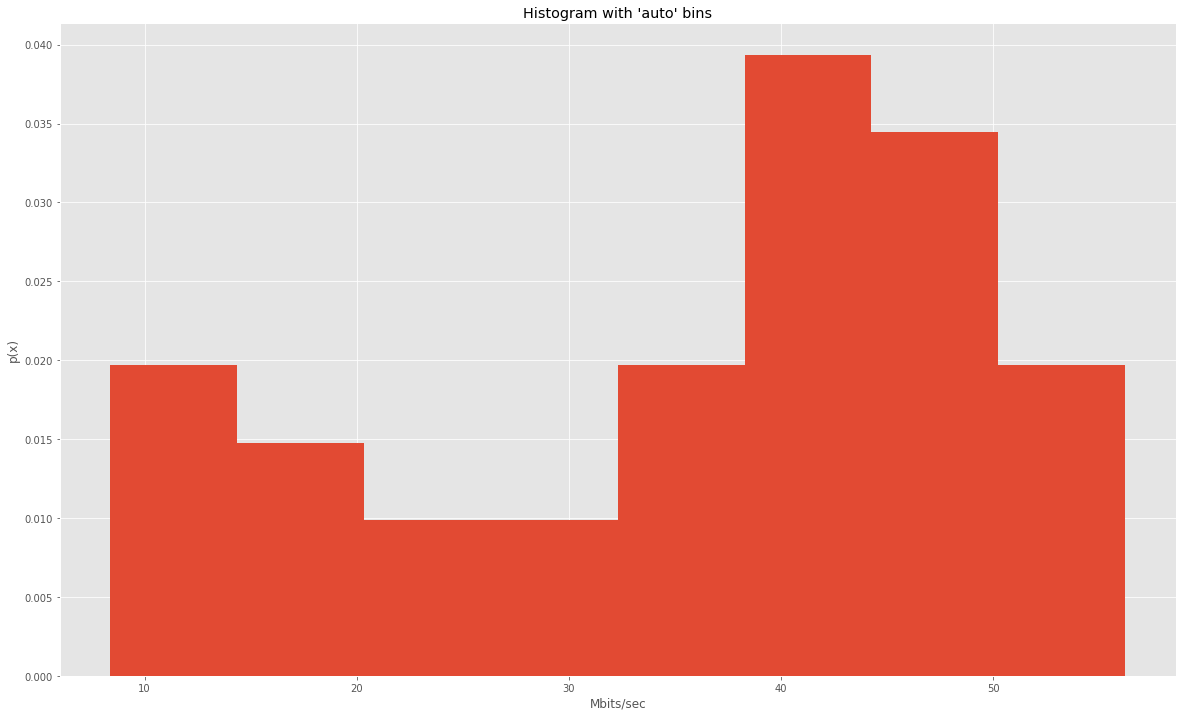

Download mean: 3.442466666666667 Mbits/s
Download deviation: 0.581719610935652 Mbits/s
Confidence interval: (3.22524899407076, 3.6596843392625735)




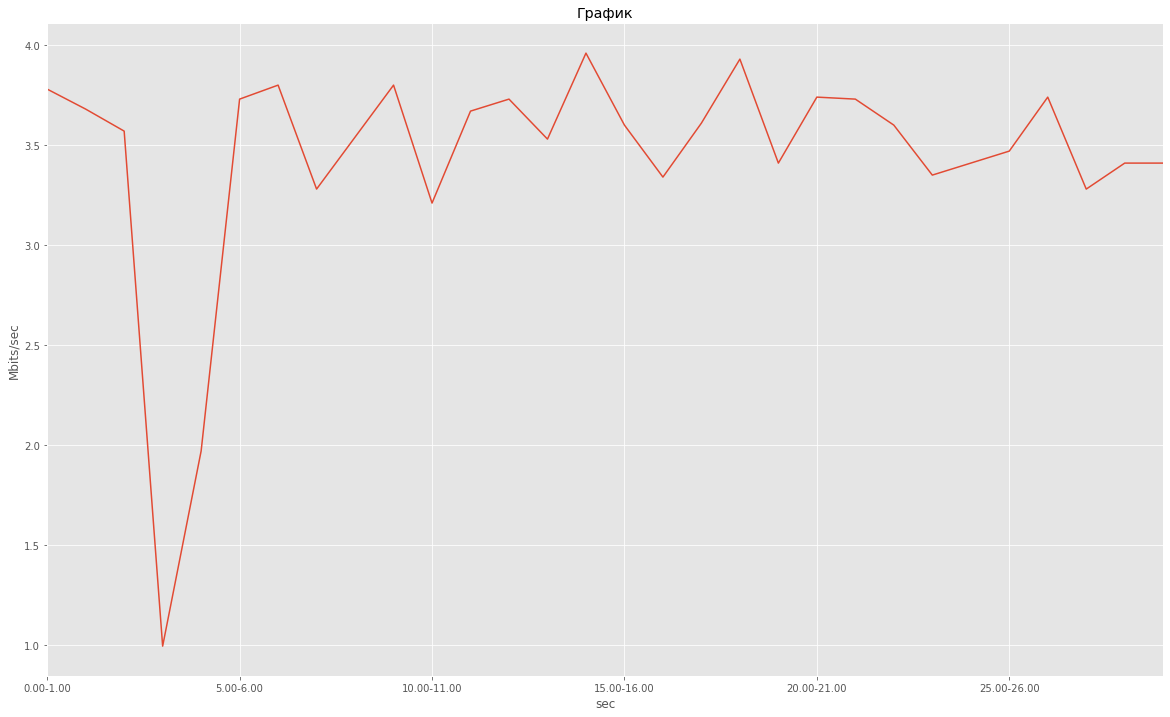

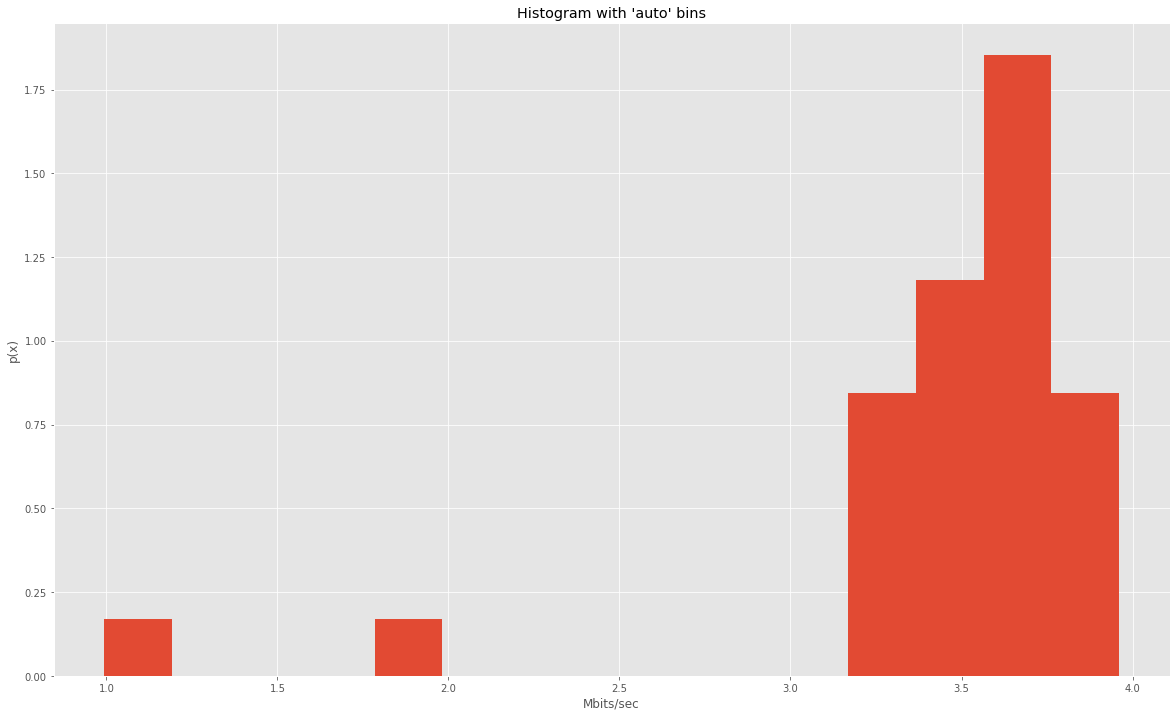

Upload data distribution approximation:


Download data distribution approximation:


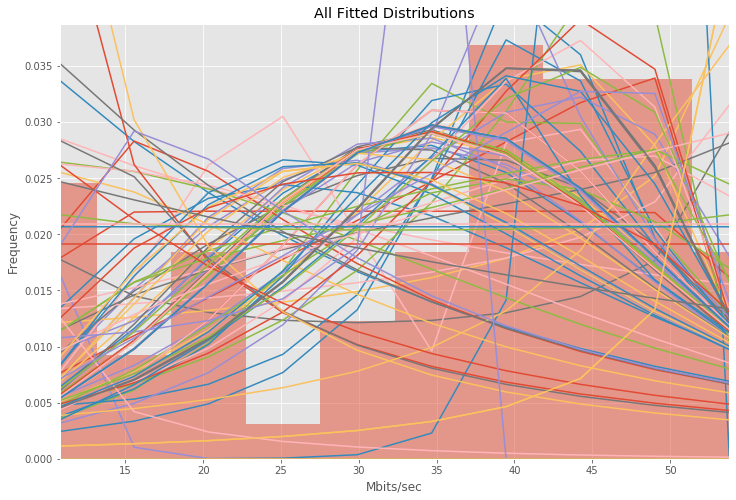

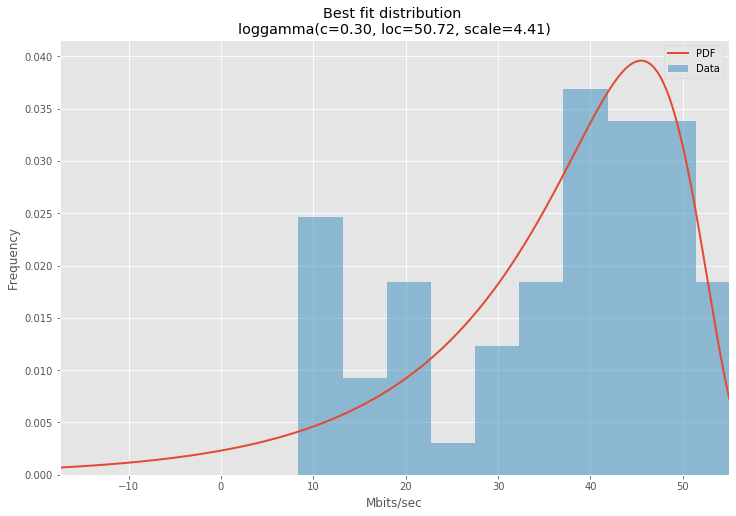

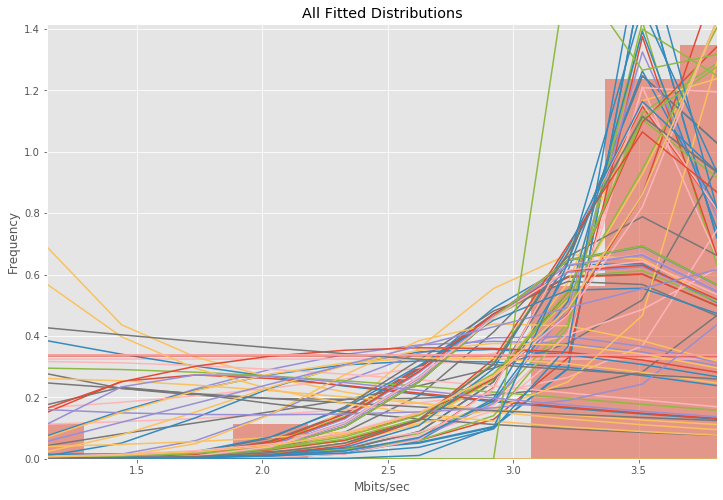

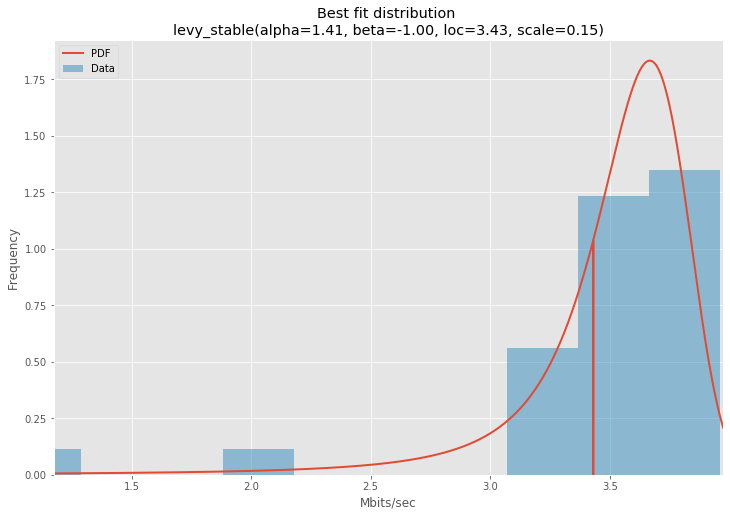

In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib
import subprocess
from statistics import mean, stdev
import matplotlib.pyplot as plt
import re
from IPython.display import clear_output
from scipy.stats import sem, t



######################################################################
############# STATISTICAL ANALYSIS SECTION


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

def distributionTest(arg):
    # Load data from statsmodels datasets
    data = pd.Series(arg)

    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=10, density=True, alpha=0.5)# Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 10, ax)
    best_dist = getattr(st, best_fit_name)

    # Update plots
    ax.set_ylim(dataYLim)
    ax.set_title(u'All Fitted Distributions')
    ax.set_xlabel(u'Mbits/sec')
    ax.set_ylabel('Frequency')

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=10, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(u'Best fit distribution \n' + dist_str)
    ax.set_xlabel(u'Mbits/sec')
    ax.set_ylabel('Frequency')


def confidenceBounds(data, confidence = 0.95):
    confidence = 0.95
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    start = m - h
    end = m + h
    return start, end


def rawDataPlot(arg):
    values, intervals = extractBandwidth(arg)
    data = pd.Series(values, index = intervals)
    ax = data.plot(figsize=(20,12))
    ax.set_title(u'График')
    ax.set_xlabel(u'sec')
    ax.set_ylabel('Mbits/sec')
    plt.figure(figsize=(20,12))
    temp = plt.hist(values, bins='auto', density = True)
    plt.title("Histogram with 'auto' bins")
    plt.xlabel("Mbits/sec")
    plt.ylabel("p(x)")
    plt.show()

    

## STATISTICAL ANALYSIS SECTION
########################################################################################### 
###########################################################################################


# direction to iperf3.exe on this local machine
path = "C:/Users/hitma/Downloads/Catalogs/iperf-3.1.3-win64"

command_upload = [path + "/iperf3", "-c", "-u", "-b 1000m", "-n 300000000"]
command_download = [path + "/iperf3", "-c", "-u", "-b 100M", "-t 30",  "-R"]

# list of public iperf3 servers to test a connection
servers = ["iperf.he.net", "speedtest.serverius.net", "iperf.eenet.ee", "iperf.volia.net",\
           "ping-ams1.online.net", "ping6.online.net", "ping.online.net", ]


def measureThroughput(command, time_limit):
    while True:
        try:
            command.insert(2, servers[-1])
            print("server: {}".format(servers[-1]))
            output = subprocess.check_output(command, encoding = 'cp866', timeout = time_limit)
        except subprocess.CalledProcessError as exception:
            print("error code: {} {}".format(exception.returncode, exception.output))
            temp = servers.pop()
            servers.insert(0, temp)
        except subprocess.TimeoutExpired as timeout:
            print("error code: {} seconds timeout was reached\n {}".format(timeout.timeout, timeout.output))
            temp = servers.pop()
            servers.insert(0, temp)
        else:
            print("No exception:")
            break
    return output
    

upload = measureThroughput(command_upload, 120)
download = measureThroughput(command_download, 120)
clear_output()

def extractBandwidth(data):
    key_s = data.find("Bandwidth")
    key_e = data.find("- - - - -")
    match1 = re.findall(r"(\d+(?:\.\d+)?)(\s[a-zA-Z]?bits/sec)", data[key_s:key_e])
    match2 = re.findall(r"\d+\.\d+-\d+\.\d+", data[key_s:key_e])
    result = []
    for element in match1:
        value = (float(element[0]))
        prefix = element[1]
        if prefix.lower() == " kbits/sec":
            value = value / 1000
        elif prefix.lower() == " bits/sec":
            value = value / 10**6
        elif prefix.lower() == " mbits/sec":
            pass
        else:
            print("Error!")
            exit(0)
        result.append(value)
    return result, match2



upload_data, _ = extractBandwidth(upload)
download_data, _ = extractBandwidth(download)
print("Upload mean: {} Mbits/s\nUpload deviation: {} Mbits/s".format(mean(upload_data), stdev(upload_data)))
print( "Confidence interval: {}\n\n".format(confidenceBounds(upload_data, 0.99)) )
rawDataPlot(upload)

print("Download mean: {} Mbits/s\nDownload deviation: {} Mbits/s".format(mean(download_data), stdev(download_data)))
print( "Confidence interval: {}\n\n".format(confidenceBounds(download_data, 0.99)) )
rawDataPlot(download)

print("Upload data distribution approximation:")
distributionTest(upload_data)

print("\n\nDownload data distribution approximation:")
distributionTest(download_data)